In [1]:
import tensorflow as tf
from tensorflow import keras
import os 
import zipfile
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import datetime as dt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
print(tf.test.is_built_with_cuda())
len(tf.config.experimental.list_physical_devices('GPU'))

True


1

In [3]:
main_dir = "Phase 1 Dataset"
shoplifter_dir = "Phase 1 Dataset/shop lifter"
notshoplifter_dir = "Phase 1 Dataset/not Shop Lifters"
all_shoplifter_dir = "Phase 1 Dataset/all shop lifter"
all_notshoplifter_dir = "Phase 1 Dataset/all not Shop lifters"
test_shoplifter_dir = "Phase 1 Dataset/test shop lifter"
test_notshoplifter_dir = "Phase 1 Dataset/test not Shop lifters"
val_shoplifter_dir = "Phase 1 Dataset/val shop lifter"
val_notshoplifter_dir = "Phase 1 Dataset/val not Shop lifters"

In [4]:
os.listdir(notshoplifter_dir)[:10]

['shop_lifter_n_0.mp4',
 'shop_lifter_n_0_1.mp4',
 'shop_lifter_n_1.mp4',
 'shop_lifter_n_10.mp4',
 'shop_lifter_n_10_1.mp4',
 'shop_lifter_n_11.mp4',
 'shop_lifter_n_118.mp4',
 'shop_lifter_n_118_1.mp4',
 'shop_lifter_n_119.mp4',
 'shop_lifter_n_119_1.mp4']

In [5]:
for dir, dirname, filename in os.walk(main_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 8 directories and 0 images in Phase 1 Dataset
Found 0 directories and 436 images in Phase 1 Dataset\all not Shop Lifters
Found 0 directories and 129 images in Phase 1 Dataset\all shop lifter
Found 0 directories and 282 images in Phase 1 Dataset\not Shop Lifters
Found 0 directories and 116 images in Phase 1 Dataset\shop lifter
Found 0 directories and 104 images in Phase 1 Dataset\test not Shop Lifters
Found 0 directories and 4 images in Phase 1 Dataset\test shop lifter
Found 0 directories and 50 images in Phase 1 Dataset\val not Shop Lifters
Found 0 directories and 9 images in Phase 1 Dataset\val shop lifter


In [6]:
SEQUENCE_LENGTH = 20
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 4

In [7]:
def load_frames(path,n_frames,frame_step,size):
    result = []
    src = cv2.VideoCapture(str(path))
    
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step
    
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start =  random.randint(0,max_start + 1)
        
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    frame = cv2.resize(frame,size)
    result.append(format_frame(frame,size))
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = cv2.resize(frame,size)
            frame = format_frame(frame,size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result =  np.array(result)[...,[2,1,0]]

    return result


In [8]:
def format_frame(frame, size):
    
    frame = tf.image.convert_image_dtype(frame, tf.float16)
#     frame = tf.image.resize_with_pad(frame, *size)
    return frame

In [10]:
def plot_vid(images):
    img = np.clip(images * 255, 0 ,255).astype(np.uint8)
    frames = []
    fig = plt.figure()
    for i in range(len(img)):
        frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                    repeat_delay=1000)
    ani.save('movie.mp4')
    plt.show()

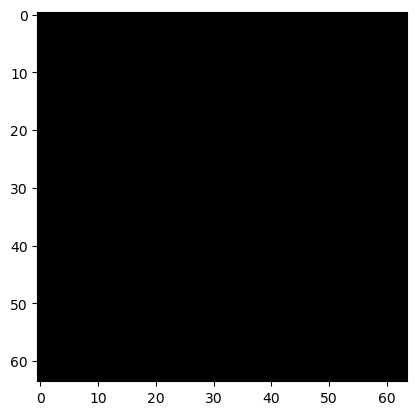

In [11]:
frames = load_frames("Phase 1 Dataset\shop lifter\shop_lifter_0.mp4",SEQUENCE_LENGTH,20,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
plot_vid(frames)

In [12]:
train_data = []
train_labels = []
test_data = []
test_labels = []
val_data = []
val_labels = []
for path in os.listdir(shoplifter_dir):
    frames = load_frames(shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    train_data.append(frames)
    train_labels.append(1)
    print(path + ": done")
for path in os.listdir(notshoplifter_dir):
    frames = load_frames(notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    train_data.append(frames)
    train_labels.append(0)
    print(path + ": done")
for path in os.listdir(test_shoplifter_dir):
    frames = load_frames(test_shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    test_data.append(frames)
    test_labels.append(1)
    print(path + ": done")
for path in os.listdir(test_notshoplifter_dir):
    frames = load_frames(test_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    test_data.append(frames)
    test_labels.append(0)
    print(path + ": done")
for path in os.listdir(val_shoplifter_dir):
    frames = load_frames(val_shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    val_data.append(frames)
    val_labels.append(1)
    print(path + ": done")
for path in os.listdir(val_notshoplifter_dir):
    frames = load_frames(val_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    val_data.append(frames)
    val_labels.append(0)
    print(path + ": done")

shop_lifter_0.mp4: done
shop_lifter_10.mp4: done
shop_lifter_100.mp4: done
shop_lifter_101.mp4: done
shop_lifter_102.mp4: done
shop_lifter_103.mp4: done
shop_lifter_104.mp4: done
shop_lifter_105.mp4: done
shop_lifter_106.mp4: done
shop_lifter_107.mp4: done
shop_lifter_108.mp4: done
shop_lifter_109.mp4: done
shop_lifter_11.mp4: done
shop_lifter_110.mp4: done
shop_lifter_111.mp4: done
shop_lifter_112.mp4: done
shop_lifter_113.mp4: done
shop_lifter_114.mp4: done
shop_lifter_115.mp4: done
shop_lifter_116.mp4: done
shop_lifter_117.mp4: done
shop_lifter_118.mp4: done
shop_lifter_119.mp4: done
shop_lifter_12.mp4: done
shop_lifter_120.mp4: done
shop_lifter_121.mp4: done
shop_lifter_122.mp4: done
shop_lifter_123.mp4: done
shop_lifter_124.mp4: done
shop_lifter_125.mp4: done
shop_lifter_126.mp4: done
shop_lifter_127.mp4: done
shop_lifter_128.mp4: done
shop_lifter_13.mp4: done
shop_lifter_14.mp4: done
shop_lifter_15.mp4: done
shop_lifter_16.mp4: done
shop_lifter_17.mp4: done
shop_lifter_18.mp4: do

shop_lifter_n_211_1.mp4: done
shop_lifter_n_212.mp4: done
shop_lifter_n_212_1.mp4: done
shop_lifter_n_213.mp4: done
shop_lifter_n_213_1.mp4: done
shop_lifter_n_214.mp4: done
shop_lifter_n_214_1.mp4: done
shop_lifter_n_215.mp4: done
shop_lifter_n_215_1.mp4: done
shop_lifter_n_216.mp4: done
shop_lifter_n_216_1.mp4: done
shop_lifter_n_217.mp4: done
shop_lifter_n_217_1.mp4: done
shop_lifter_n_218.mp4: done
shop_lifter_n_218_1.mp4: done
shop_lifter_n_21_1.mp4: done
shop_lifter_n_22.mp4: done
shop_lifter_n_22_1.mp4: done
shop_lifter_n_23.mp4: done
shop_lifter_n_23_1.mp4: done
shop_lifter_n_24.mp4: done
shop_lifter_n_24_1.mp4: done
shop_lifter_n_25.mp4: done
shop_lifter_n_25_1.mp4: done
shop_lifter_n_26.mp4: done
shop_lifter_n_26_1.mp4: done
shop_lifter_n_27.mp4: done
shop_lifter_n_27_1.mp4: done
shop_lifter_n_28.mp4: done
shop_lifter_n_28_1.mp4: done
shop_lifter_n_29.mp4: done
shop_lifter_n_29_1.mp4: done
shop_lifter_n_2_1.mp4: done
shop_lifter_n_3.mp4: done
shop_lifter_n_30.mp4: done
shop_l

In [9]:
def read_video_as_array(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_frame = cv2.resize(frame, (64, 64))
            frames.append(resized_frame)
        else:
            break
    cap.release()
    frames_array = np.array(frames)[::3]
    frames_array=frames_array[frames_array.shape[0]-20:frames_array.shape[0]]
    return frames_array

In [10]:
train_data = []
train_labels = []
test_data = []
test_labels = []
val_data = []
val_labels = []
for path in os.listdir(shoplifter_dir):
    frames = read_video_as_array(shoplifter_dir + '/' +path)
    train_data.append(frames)
    train_labels.append(1)
    print(path + ": done")
for path in os.listdir(notshoplifter_dir):
    frames = read_video_as_array(notshoplifter_dir + '/' + path)
    train_data.append(frames)
    train_labels.append(0)
    print(path + ": done")
for path in os.listdir(test_shoplifter_dir):
    frames = read_video_as_array(test_shoplifter_dir + '/' +path)
    test_data.append(frames)
    test_labels.append(1)
    print(path + ": done")
for path in os.listdir(test_notshoplifter_dir):
    frames = read_video_as_array(test_notshoplifter_dir + '/' + path)
    test_data.append(frames)
    test_labels.append(0)
    print(path + ": done")
for path in os.listdir(val_shoplifter_dir):
    frames = read_video_as_array(val_shoplifter_dir + '/' +path)
    val_data.append(frames)
    val_labels.append(1)
    print(path + ": done")
for path in os.listdir(val_notshoplifter_dir):
    frames = read_video_as_array(val_notshoplifter_dir + '/' + path)
    val_data.append(frames)
    val_labels.append(0)
    print(path + ": done")

shop_lifter_0.mp4: done
shop_lifter_10.mp4: done
shop_lifter_100.mp4: done
shop_lifter_101.mp4: done
shop_lifter_102.mp4: done
shop_lifter_103.mp4: done
shop_lifter_104.mp4: done
shop_lifter_105.mp4: done
shop_lifter_106.mp4: done
shop_lifter_107.mp4: done
shop_lifter_108.mp4: done
shop_lifter_109.mp4: done
shop_lifter_11.mp4: done
shop_lifter_110.mp4: done
shop_lifter_111.mp4: done
shop_lifter_112.mp4: done
shop_lifter_113.mp4: done
shop_lifter_114.mp4: done
shop_lifter_115.mp4: done
shop_lifter_116.mp4: done
shop_lifter_117.mp4: done
shop_lifter_118.mp4: done
shop_lifter_119.mp4: done
shop_lifter_12.mp4: done
shop_lifter_120.mp4: done
shop_lifter_121.mp4: done
shop_lifter_122.mp4: done
shop_lifter_123.mp4: done
shop_lifter_124.mp4: done
shop_lifter_125.mp4: done
shop_lifter_126.mp4: done
shop_lifter_127.mp4: done
shop_lifter_128.mp4: done
shop_lifter_13.mp4: done
shop_lifter_14.mp4: done
shop_lifter_15.mp4: done
shop_lifter_16.mp4: done
shop_lifter_17.mp4: done
shop_lifter_18.mp4: do

shop_lifter_n_211_1.mp4: done
shop_lifter_n_212.mp4: done
shop_lifter_n_212_1.mp4: done
shop_lifter_n_213.mp4: done
shop_lifter_n_213_1.mp4: done
shop_lifter_n_214.mp4: done
shop_lifter_n_214_1.mp4: done
shop_lifter_n_215.mp4: done
shop_lifter_n_215_1.mp4: done
shop_lifter_n_216.mp4: done
shop_lifter_n_216_1.mp4: done
shop_lifter_n_217.mp4: done
shop_lifter_n_217_1.mp4: done
shop_lifter_n_218.mp4: done
shop_lifter_n_218_1.mp4: done
shop_lifter_n_21_1.mp4: done
shop_lifter_n_22.mp4: done
shop_lifter_n_22_1.mp4: done
shop_lifter_n_23.mp4: done
shop_lifter_n_23_1.mp4: done
shop_lifter_n_24.mp4: done
shop_lifter_n_24_1.mp4: done
shop_lifter_n_25.mp4: done
shop_lifter_n_25_1.mp4: done
shop_lifter_n_26.mp4: done
shop_lifter_n_26_1.mp4: done
shop_lifter_n_27.mp4: done
shop_lifter_n_27_1.mp4: done
shop_lifter_n_28.mp4: done
shop_lifter_n_28_1.mp4: done
shop_lifter_n_29.mp4: done
shop_lifter_n_29_1.mp4: done
shop_lifter_n_2_1.mp4: done
shop_lifter_n_3.mp4: done
shop_lifter_n_30.mp4: done
shop_l

In [258]:
data = []
labels = []
for path in os.listdir(all_shoplifter_dir):
    frames = load_frames(all_shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    data.append(frames)
    labels.append(1)
#     print(path + ": done")
for path in os.listdir(all_notshoplifter_dir):
    frames = load_frames(all_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    data.append(frames)
    labels.append(0)
#     print(path + ": done")

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels,
#                                                    test_size=0.3,shuffle=True,
#                                                    random_state = 0)


In [14]:
X_train = np.array(train_data)
y_train = np.array(train_labels)
X_test = np.array(test_data)
y_test = np.array(test_labels)
X_val = np.array(val_data)
y_val = np.array(val_labels)

In [13]:
X = np.array(data)
y = np.array(labels)

NameError: name 'data' is not defined

In [15]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

In [260]:
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [22]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(1, activation = "sigmoid"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [23]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 98, 98, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 49, 49, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 49, 49, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 47, 47, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 24, 24, 8)    0         
 3D)                                                             
                                                        

In [26]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(np.array(y_train)), y=np.array(y_train))

In [27]:
print(class_weights)

class_weights_dict = dict(enumerate(class_weights))

[0.70567376 1.71551724]


In [26]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = X_train, y = y_train, epochs = 50, batch_size = BATCH_SIZE,
                                                     shuffle = True, validation_split = 0.3, class_weight=class_weights_dict, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/70
71/71 [==============================] - 74s 861ms/step - loss: 0.7581 - accuracy: 0.4270 - val_loss: 0.7982 - val_accuracy: 0.0000e+00
Epoch 2/70
71/71 [==============================] - 61s 859ms/step - loss: 0.7414 - accuracy: 0.4270 - val_loss: 1.0858 - val_accuracy: 0.0000e+00
Epoch 3/70
71/71 [==============================] - 62s 869ms/step - loss: 0.7257 - accuracy: 0.4270 - val_loss: 0.7502 - val_accuracy: 0.3636
Epoch 4/70
71/71 [==============================] - 61s 861ms/step - loss: 0.4762 - accuracy: 0.7580 - val_loss: 0.2856 - val_accuracy: 0.8264
Epoch 5/70
71/71 [==============================] - 61s 865ms/step - loss: 0.1126 - accuracy: 0.9609 - val_loss: 0.0772 - val_accuracy: 0.9421
Epoch 6/70
71/71 [==============================] - 61s 858ms/step - loss: 0.1037 - accuracy: 0.9715 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 7/70
71/71 [==============================] - 62s 868ms/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.0032 - val_accuracy

In [27]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 234ms/step - loss: 2.9918 - accuracy: 0.5583


In [28]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model05.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [35]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

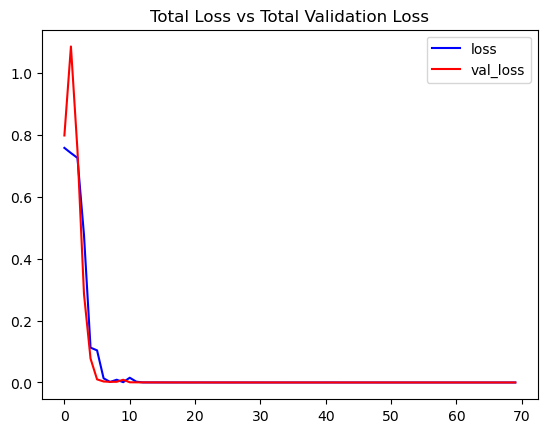

In [30]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

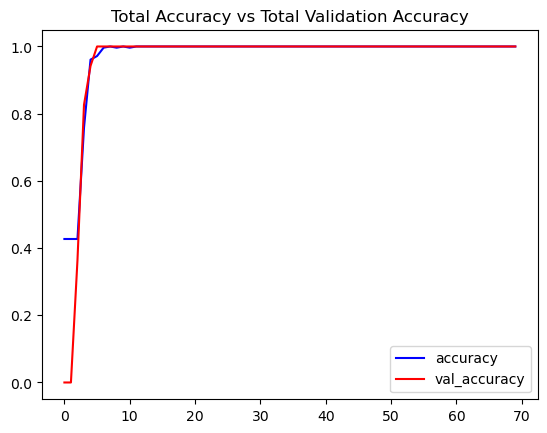

In [31]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [278]:
def read_video_as_array(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_frame = cv2.resize(frame, (64, 64))
            frames.append(resized_frame)
        else:
            break
    cap.release()
    frames_array = np.array(frames)[::3]
    frames_array=frames_array[frames_array.shape[0]-20:frames_array.shape[0]]
    return frames_array

In [20]:
from tensorflow.keras.models import load_model
new_model = load_model("convlstm_model.h5")

In [28]:
model_evaluation_history = new_model.evaluate(X_test, y_test)

5/5 [==============================] - 6s 188ms/step - loss: 3.2279e-12 - accuracy: 1.0000


In [6]:
import requests

url = "https://github.com/AbuAlHagag/stp_models/raw/main/convlstm_model.h5"
local_filename = "my_model.h5"

# Download the model file from the URL
response = requests.get(url)
with open(local_filename, "wb") as f:
    f.write(response.content)

loaded_model = tf.keras.models.load_model(local_filename)

In [277]:
train_data = []
train_labels = []
test_data = []
test_labels = []
val_data = []
val_labels = []
i=0
for path in os.listdir(shoplifter_dir):
    i++
    frames = load_frames(shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    train_data.append(frames)
    train_labels.append(1)
    print(path + ": done")
i=0
for path in os.listdir(notshoplifter_dir):
    i++
    frames = load_frames(notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    train_data.append(frames)
    train_labels.append(0)
    print(path + ": done")
i=0
for path in os.listdir(test_shoplifter_dir):
    i++
    frames = load_frames(test_shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    test_data.append(frames)
    test_labels.append(1)
    print(path + ": done")
i=0
for path in os.listdir(test_notshoplifter_dir):
    i++
    frames = load_frames(test_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    test_data.append(frames)
    test_labels.append(0)
    print(path + ": done")
i=0
for path in os.listdir(val_shoplifter_dir):
    frames = load_frames(val_shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    val_data.append(frames)
    val_labels.append(1)
    print(path + ": done")
i=0
for path in os.listdir(val_notshoplifter_dir):
    frames = load_frames(val_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    val_data.append(frames)
    val_labels.append(0)
    print(path + ": done")
i=0

SyntaxError: invalid syntax (297471122.py, line 9)

In [148]:
data = []
labels = []
cnt=0
for path in os.listdir(all_shoplifter_dir):
    frames = load_frames(all_shoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    data.append(frames)
    labels.append(1)
#     print(path + ": done" +" Shape : ")
    print(frames.shape)
for path in os.listdir(all_notshoplifter_dir):
    cnt+=1
    frames = load_frames(all_notshoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    data.append(frames)
    labels.append(0)
#     print(path + ": done" +" Shape : ")
    print(frames.shape)
    if cnt==170:
        break

(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64, 64, 3)
(20, 64,

In [149]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(labels),
                                                   test_size=0.1,shuffle=True,
                                                   random_state = 10)

In [26]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(128))
                                      
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))    
    model.add(Dense(1, activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [27]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 4, 4, 32)    

In [28]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = X_train, y = y_train, epochs = 100, batch_size = 32,
                                             shuffle = False, validation_data = (X_val,y_val))

Epoch 1/100
13/13 [==============================] - 2s 75ms/step - loss: 0.7267 - accuracy: 0.2286 - val_loss: 0.6752 - val_accuracy: 0.8475
Epoch 2/100
13/13 [==============================] - 1s 45ms/step - loss: 0.6580 - accuracy: 0.7437 - val_loss: 0.6256 - val_accuracy: 0.8475
Epoch 3/100
13/13 [==============================] - 1s 44ms/step - loss: 0.6350 - accuracy: 0.7085 - val_loss: 0.5562 - val_accuracy: 0.8475
Epoch 4/100
13/13 [==============================] - 1s 44ms/step - loss: 0.6126 - accuracy: 0.7085 - val_loss: 0.5043 - val_accuracy: 0.8475
Epoch 5/100
13/13 [==============================] - 1s 44ms/step - loss: 0.6118 - accuracy: 0.7085 - val_loss: 0.4669 - val_accuracy: 0.8475
Epoch 6/100
13/13 [==============================] - 1s 44ms/step - loss: 0.6069 - accuracy: 0.7085 - val_loss: 0.4587 - val_accuracy: 0.8475
Epoch 7/100
13/13 [==============================] - 1s 44ms/step - loss: 0.6086 - accuracy: 0.7085 - val_loss: 0.4669 - val_accuracy: 0.8475
Epoch 

KeyboardInterrupt: 

In [29]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 0.3652 - accuracy: 0.9630


In [30]:
y_pred = LRCN_model.predict(X_test)
y_pred_binary = (y_pred>=0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)
print(f1)

0.0


In [32]:
# Compute F1 score
f1 = f1_score(y_test, y_pred_binary)

In [33]:
f1

1.0

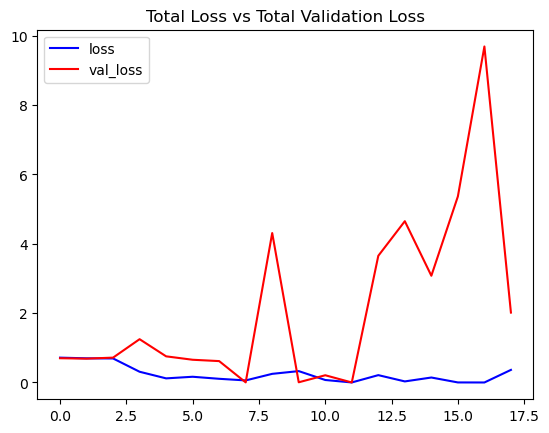

In [38]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

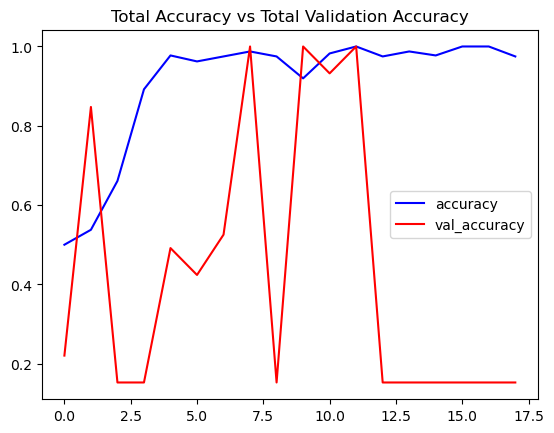

In [39]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [34]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [46]:
def create_resnet_video_model(input_shape, sequence_length):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()

    model.add(TimeDistributed(base_model, input_shape=(sequence_length,) + input_shape))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(512, return_sequences=False))
    
    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [47]:
Resnet_model=create_resnet_video_model((IMAGE_HEIGHT,IMAGE_WIDTH,3),SEQUENCE_LENGTH)

In [48]:
Resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 20, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 8192)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 512)               17827840  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

In [50]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
Resnet_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(), metrics = ["accuracy"])

# Start training the model.
Resnet_model_training_history = Resnet_model.fit(x = X, y = y, epochs = 70, batch_size = 4 , validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70


ResourceExhaustedError:  OOM when allocating tensor with shape[80,512,13,13] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_4/time_distributed_48/conv3_block2_3_bn/FusedBatchNormV3
 (defined at C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\normalization\batch_normalization.py:599)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_157857]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_4/time_distributed_48/conv3_block2_3_bn/FusedBatchNormV3:
In[0] sequential_4/time_distributed_48/conv3_block2_3_conv/BiasAdd (defined at C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\convolutional.py:265)	
In[1] sequential_4/time_distributed_48/conv3_block2_3_bn/ReadVariableOp:	
In[2] sequential_4/time_distributed_48/conv3_block2_3_bn/ReadVariableOp_1:	
In[3] sequential_4/time_distributed_48/conv3_block2_3_bn/FusedBatchNormV3/ReadVariableOp:	
In[4] sequential_4/time_distributed_48/conv3_block2_3_bn/FusedBatchNormV3/ReadVariableOp_1:

Operation defined at: (most recent call last)
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 528, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 1764, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\asyncio\events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\creat\AppData\Local\Temp\ipykernel_8704\2277924547.py", line 8, in <module>
>>>     Resnet_model_training_history = Resnet_model.fit(x = X, y = y, epochs = 70, batch_size = 4 , validation_split = 0.2, callbacks = [early_stopping_callback])
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1088, in __call__
>>>     self._set_mask_metadata(inputs, outputs, input_masks, not eager)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 2555, in _set_mask_metadata
>>>     output_masks = self.compute_mask(inputs, previous_mask)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\wrappers.py", line 343, in compute_mask
>>>     output_mask = self.layer.compute_mask(inner_inputs, inner_mask)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 428, in compute_mask
>>>     output_tensors = self._run_internal_graph(inputs, mask=mask)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 767, in call
>>>     outputs = self._fused_batch_norm(inputs, training=training)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 624, in _fused_batch_norm
>>>     training, train_op, _fused_batch_norm_inference)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\utils\control_flow_util.py", line 106, in smart_cond
>>>     pred, true_fn=true_fn, false_fn=false_fn, name=name)
>>> 
>>>   File "C:\Users\creat\anaconda3\envs\tensor\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 599, in _fused_batch_norm_training
>>>     exponential_avg_factor=exponential_avg_factor)
>>> 

In [29]:
def create_Inception_model(input_shape, sequence_length):
    base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()

    model.add(TimeDistributed(base_model, input_shape=(sequence_length,) + input_shape))

#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(512, return_sequences=False))
    
    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [30]:
Inception_model = create_Inception_model((IMAGE_HEIGHT,IMAGE_WIDTH,3),SEQUENCE_LENGTH)

In [31]:
Inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 20, 1, 1, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 512)               5244928   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)               

In [195]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
Inception_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(), metrics = ["accuracy"])

# Start training the model.
Inception_model_training_history = Inception_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 4 ,class_weight=class_weights_dict,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

NameError: name 'Inception_model' is not defined

In [31]:
def create_MobileNet_model(input_shape, sequence_length):
    base_model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()

    model.add(TimeDistributed(base_model, input_shape=(sequence_length,) + input_shape))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(64, return_sequences=False))
    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [32]:
MobileNet_model = create_MobileNet_model((IMAGE_HEIGHT,IMAGE_WIDTH,3),SEQUENCE_LENGTH)

print("Model Created Successfully!")

Model Created Successfully!


In [33]:
MobileNet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 20, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 64)                278784    
                                                                 
 dense_15 (Dense)            (None, 256)               16640     
                                                      

In [34]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true , dtype=tf.float32)  # Convert to float32

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    return (2. * intersection + 1.) / (union + 1.)  # Adding 1 to avoid division by zero

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [35]:
print(X.shape)

NameError: name 'X' is not defined

In [39]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
MobileNet_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7), metrics = ["accuracy"])

# Start training the model.
MobileNet_model_training_history = MobileNet_model.fit(x = X_train, y = y_train, epochs = 10, batch_size = 4,
                                             shuffle = True, validation_data = (X_val,y_val), callbacks = [early_stopping_callback])

Epoch 1/10
100/100 [==============================] - 10s 66ms/step - loss: 0.6716 - accuracy: 0.6432 - val_loss: 0.7290 - val_accuracy: 0.3559
Epoch 2/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6726 - accuracy: 0.6156 - val_loss: 0.7384 - val_accuracy: 0.3051
Epoch 3/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6700 - accuracy: 0.6457 - val_loss: 0.7289 - val_accuracy: 0.3220
Epoch 4/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6655 - accuracy: 0.6683 - val_loss: 0.7314 - val_accuracy: 0.3390
Epoch 5/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6720 - accuracy: 0.6181 - val_loss: 0.7331 - val_accuracy: 0.3051
Epoch 6/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6663 - accuracy: 0.6432 - val_loss: 0.7304 - val_accuracy: 0.3220
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 0.6606 - accuracy: 0.7060 - val_loss: 0.7328 - val_accuracy: 0.322

In [275]:
# Evaluate the trained model.
model_evaluation_history = MobileNet_model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 825ms/step - loss: 0.5167 - accuracy: 0.6667


In [276]:
y_pred = MobileNet_model.predict(X_test)
y_pred_binary = (y_pred>0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)
print(f1)

0.6428571428571429


In [180]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'MobileNet_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
MobileNet_model.save(model_file_name)